# Forward computation

Recall, to compute source estimates, one typically assumes:
    
$$M = GX + E$$

where $M \in \mathbb{R}^{C \times T}$ is the sensor data, $G \in \mathbb{R}^{C \times S}$ is the lead-field matrix, $X \in \mathbb{R}^{S \times T}$ is the source time course (stc) and $E \in \mathbb{R}^{C \times T}$ is additive Gaussian noise

The lead-field matrix or forward operator $G$ is computed using the physics of the problem. It is what we will focus on here

In [1]:
import matplotlib.pyplot as plt

from IPython.display import Image
from mayavi import mlab
mlab.init_notebook('png')

Notebook initialized with png backend.


# Computing the forward operator

To compute a forward operator we need:

   - the BEM surfaces
   - a -trans.fif file that contains the coregistration info
   - a source space

In [2]:
import mne
from mne.datasets import sample

data_path = sample.data_path()

# the raw file containing the channel location + types
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'

# The transformation file obtained by coregistration
trans = data_path + '/MEG/sample/sample_audvis_raw-trans.fif'
# The paths to freesurfer reconstructions
subjects_dir = data_path + '/subjects'

## Compute and visualize BEM surfaces

Computing the BEM surfaces requires FreeSurfer and makes use of either of the two following command line tools:

* [mne watershed_bem](http://martinos.org/mne/dev/generated/commands.html#mne-watershed-bem)
* [mne flash_bem](http://martinos.org/mne/dev/generated/commands.html#mne-flash-bem)

Here we'll assume it's already computed. It takes a few minutes per subject.

So first look at the BEM surfaces.

For EEG we use 3 layers (inner skull, outer skull, and skin) while for MEG 1 layer (inner skull) is enough.

Using surface: /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/subjects/sample/bem/inner_skull.surf
Using surface: /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/subjects/sample/bem/outer_skull.surf
Using surface: /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/subjects/sample/bem/outer_skin.surf


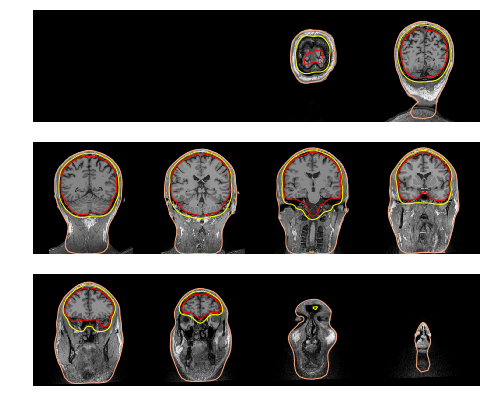

In [3]:
%matplotlib inline
mne.viz.plot_bem(subject='sample', subjects_dir=subjects_dir,
                 orientation='coronal');

In [4]:
conductivity = (0.3,)  # for single layer
# conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(subject='sample', ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 4th to 4th subdivision of an icosahedron (n_tri: 5120 -> 5120)
inner skull CM is   0.67 -10.01  44.26 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


### Visualization the coregistration

The coregistration is operation that allows to position the head and the sensors in a common coordinate system. In the MNE software the transformation to align the head and the sensors is stored in a so called *trans* file. It is a FIF file that ends with `-trans.fif`. 

It can be obtained with 
* mne_analyze (Unix tools)
* mne.gui.coregistration (in Python), or
* mrilab if you're using a Neuromag system.

For the Python version see http://martinos.org/mne/dev/generated/mne.gui.coregistration.html

Here we assume the coregistration is done, so we just visually check the alignment with the following code.

    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
Using outer_skin.surf for head surface.
Getting helmet for system 306m


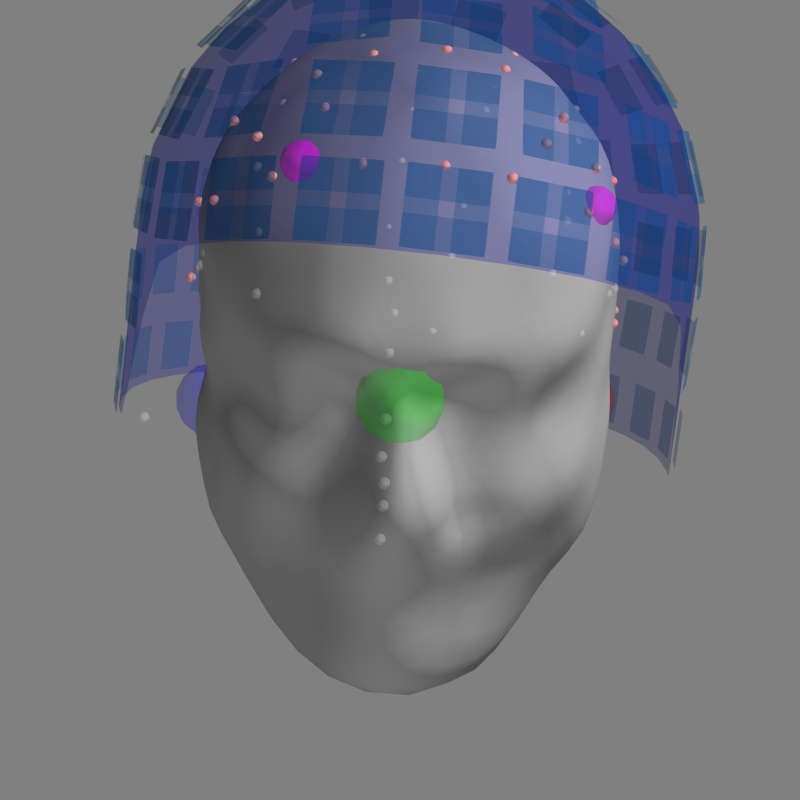

In [5]:
info = mne.io.read_info(raw_fname)
fig = mne.viz.plot_alignment(info, trans, subject='sample', dig=True,
                             subjects_dir=subjects_dir, verbose=True);
mlab.savefig('coreg.jpg')
Image(filename='coreg.jpg', width=500)

In [6]:
mlab.close()

## Compute Source Space

The source space defines the position of the candidate source locations.

The following code compute such a source space with an OCT-6 resolution.

In [7]:
mne.set_log_level('WARNING')
subject = 'sample'
src = mne.setup_source_space(subject, spacing='oct6',
                             subjects_dir=subjects_dir,
                             add_dist=False)

In [8]:
src

<SourceSpaces: [<surface (lh), n_vertices=155407, n_used=4098, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=156866, n_used=4098, coordinate_frame=MRI (surface RAS)>]>

src contains two parts, one for the left hemisphere (4098 locations) and one for the right hemisphere (4098 locations).

Let's write a few lines of mayavi to see what it contains

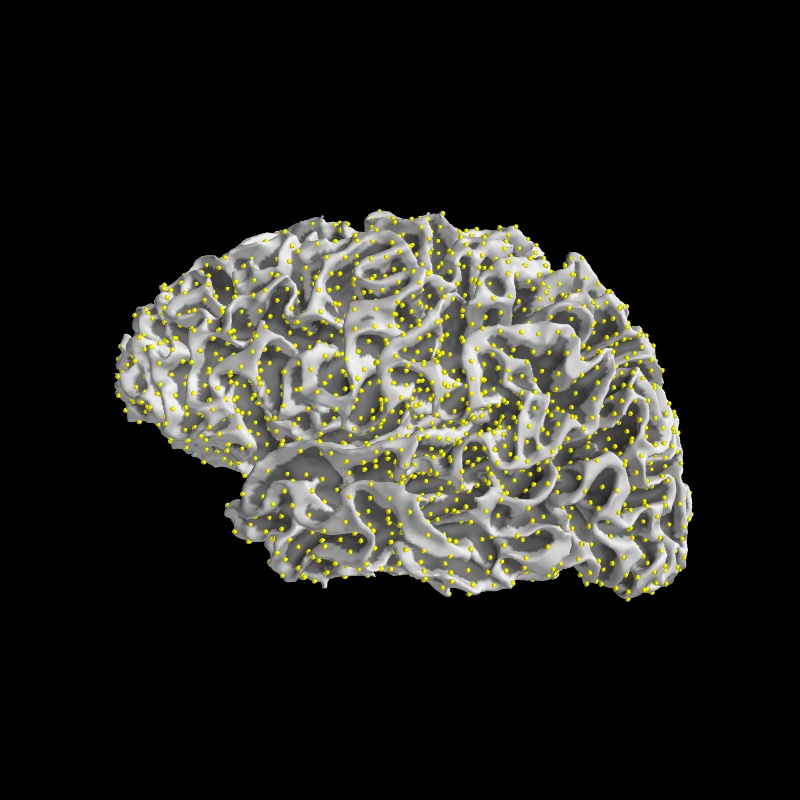

In [9]:
import numpy as np
from surfer import Brain

brain = Brain('sample', 'lh', 'white', subjects_dir=subjects_dir)
surf = brain.geo['lh']

vertidx = np.where(src[0]['inuse'])[0]

mlab.points3d(surf.x[vertidx], surf.y[vertidx],
              surf.z[vertidx], color=(1, 1, 0), scale_factor=1.5)

mlab.savefig('source_space_subsampling.jpg')
Image(filename='source_space_subsampling.jpg', width=500)

Since it's hard to see the source points on the walls of the sulcus, it is common practice to inflate the white matter surface

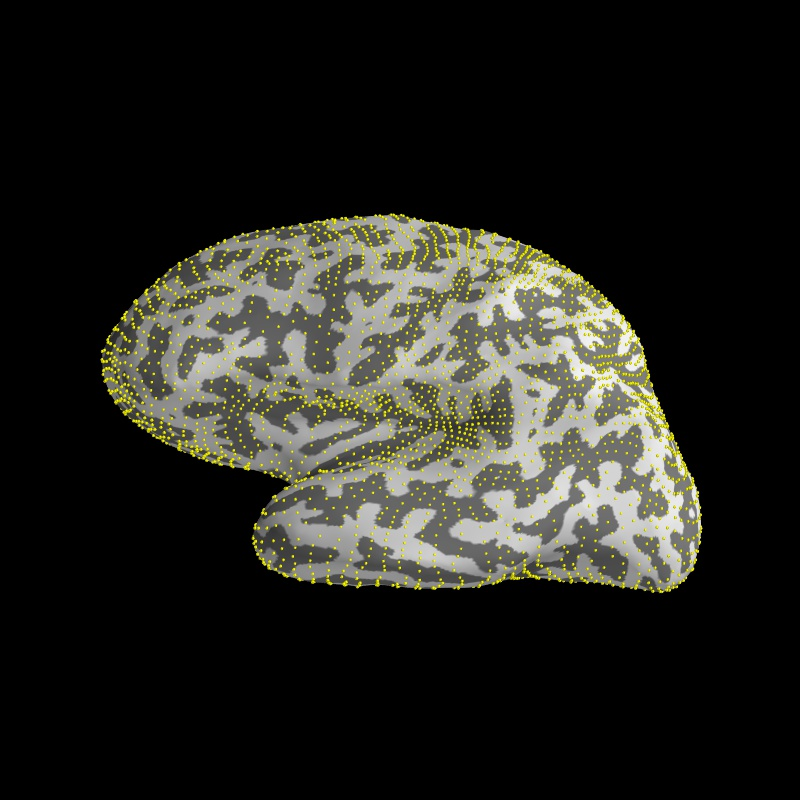

In [10]:
brain = Brain('sample', 'lh', 'inflated', subjects_dir=subjects_dir)
surf = brain.geo['lh']

mlab.points3d(surf.x[vertidx], surf.y[vertidx],
              surf.z[vertidx], color=(1, 1, 0), scale_factor=1.5)

mlab.savefig('source_space_subsampling.jpg')
Image(filename='source_space_subsampling.jpg', width=500)

In [11]:
mlab.close()

### Compute forward solution

We can now compute the forward solution.

To reduce computation we'll just compute a single layer BEM
(just inner skull) that can then be used for MEG (not EEG).

In [12]:
# Name of the forward to read (precomputed) or compute
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'
fwd = mne.make_forward_solution(raw_fname, trans=trans, src=src, bem=bem,
                                meg=True, # include MEG channels
                                eeg=False, # include EEG channels
                                mindist=5.0, # ignore sources <= 5mm from inner skull
                                n_jobs=1) # number of jobs to run in parallel

In [13]:
fwd

<Forward | MEG channels: 306 | EEG channels: 0 | Source space: Surface with 7498 vertices | Source orientation: Free>

Or read the EEG/MEG file from disk

In [14]:
fwd = mne.read_forward_solution(fwd_fname)

In [15]:
fwd

<Forward | MEG channels: 306 | EEG channels: 60 | Source space: Surface with 7498 vertices | Source orientation: Free>

Convert to surface orientation for cortically constrained inverse modeling

In [16]:
fwd = mne.convert_forward_solution(fwd, surf_ori=True)
leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

Leadfield size : 366 sensors x 22494 dipoles


# Sensitivy maps

Recall we had the gain matrix $G \in \mathbb{R}^{S \times C}$. 

A column in this matrix $g \in \mathbb{R}^{C}$ tells us how much each sensor is to a particular source

We can compute the sensitivity $a_s$ of the signals to each source point as:
    
$$a_s = \sqrt(g^{\top}g)$$

In [17]:
grad_map = mne.sensitivity_map(fwd, ch_type='grad', mode='fixed')
mag_map = mne.sensitivity_map(fwd, ch_type='mag', mode='fixed')
eeg_map = mne.sensitivity_map(fwd, ch_type='eeg', mode='fixed')

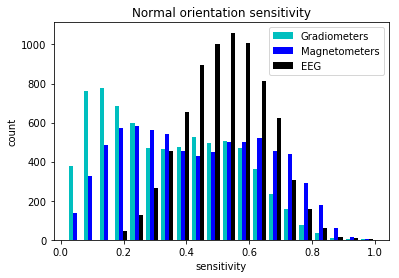

In [18]:
%matplotlib inline
plt.hist([grad_map.data.ravel(), mag_map.data.ravel(), eeg_map.data.ravel()],
          bins=20, label=['Gradiometers', 'Magnetometers', 'EEG'],
         color=['c', 'b', 'k'])
plt.legend()
plt.title('Normal orientation sensitivity')
plt.xlabel('sensitivity')
plt.ylabel('count');

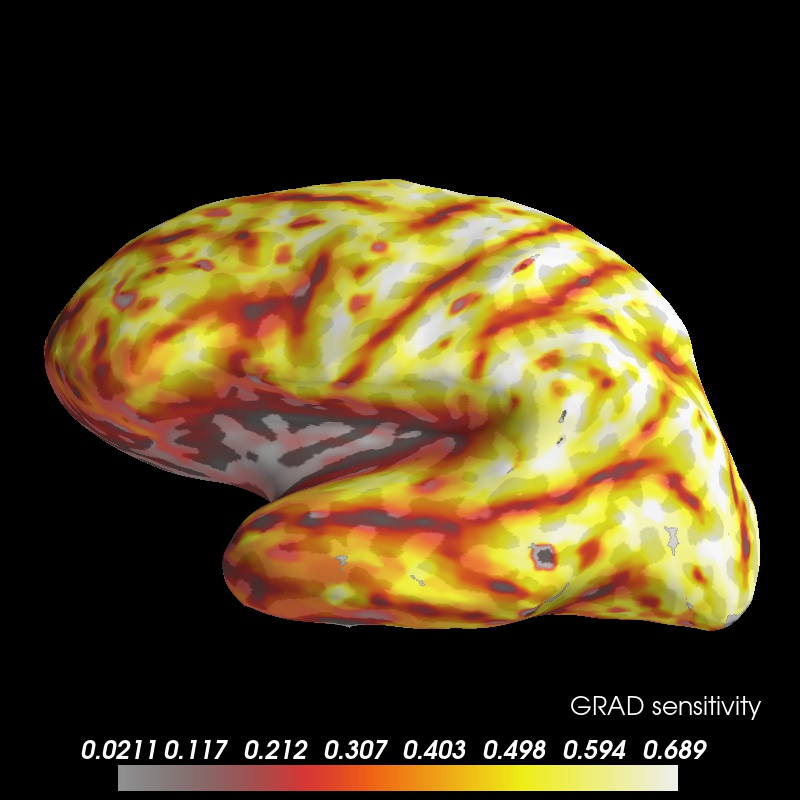

In [19]:
clim = dict(kind='percent', lims=(0.0, 50, 95), smoothing_steps=3)  # let's see single dipoles
brain = grad_map.plot(subject='sample', time_label='GRAD sensitivity', surface='inflated',
                      subjects_dir=subjects_dir, clim=clim, smoothing_steps=8, alpha=0.85);
view = 'lat'
brain.show_view(view)
brain.save_image('sensitivity_map_grad_%s.jpg' % view)
Image(filename='sensitivity_map_grad_%s.jpg' % view, width=400)

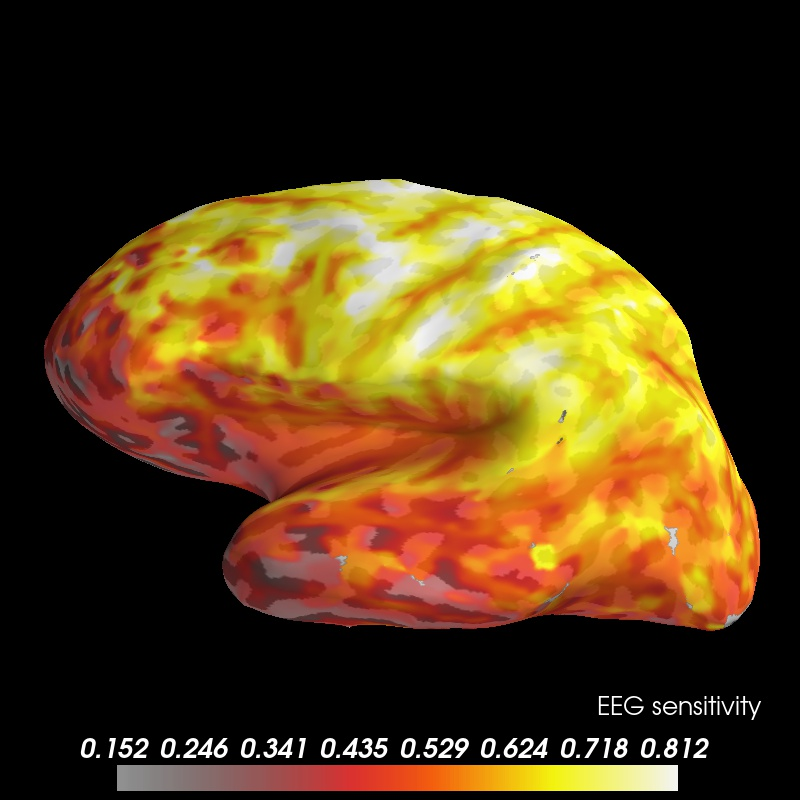

In [20]:
clim = dict(kind='percent', lims=(0.0, 50, 99), smoothing_steps=3)  # let's see single dipoles
brain = eeg_map.plot(subject='sample', time_label='EEG sensitivity', surface='inflated',
                     subjects_dir=subjects_dir, clim=clim, smoothing_steps=8, alpha=0.9);
view = 'lat'
brain.show_view(view)
brain.save_image('sensitivity_map_eeg_%s.jpg' % view)
Image(filename='sensitivity_map_eeg_%s.jpg' % view, width=400)

In [21]:
mlab.close()

# Visualizing field lines based on coregistration

In [22]:
from mne import read_evokeds
from mne.datasets import sample
from mne import make_field_map

data_path = sample.data_path()

raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

subjects_dir = data_path + '/subjects'
evoked_fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
trans_fname = data_path + '/MEG/sample/sample_audvis_raw-trans.fif'

In [23]:
make_field_map?

In [24]:
# If trans_fname is set to None then only MEG estimates can be visualized

condition = 'Left Auditory'
evoked_fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
evoked = mne.read_evokeds(evoked_fname, condition=condition, baseline=(-0.2, 0.0))

# Compute the field maps to project MEG and EEG data to MEG helmet
# and scalp surface
maps = mne.make_field_map(evoked, trans=trans, subject='sample',
                      subjects_dir=subjects_dir, n_jobs=1)

# explore several points in time
field_map = evoked.plot_field(maps, time=.1);

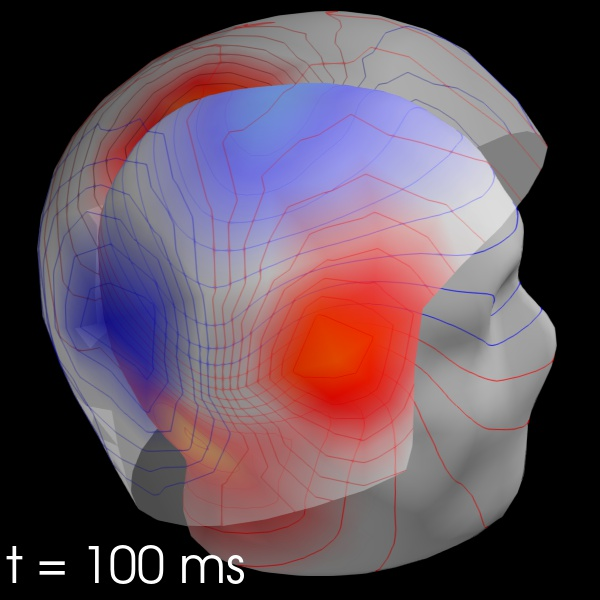

In [25]:
from mayavi import mlab
mlab.savefig('field_map.jpg')
from IPython.display import Image
Image(filename='field_map.jpg', width=800)

In [26]:
mlab.close()

## Exercise

Plot the sensitivity maps for EEG and compare it with the MEG, can you justify the claims that:

- MEG is not sensitive to radial sources
- EEG is more sensitive to deep sources

Why don't we see any dipoles on the gyri?